In [1]:
### 0. Initial Setup
import os
import numpy as np
import random
import warnings
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from skopt import BayesSearchCV
from skopt.space import Integer, Real

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = str(1)
np.random.seed(1)
random.seed(1)
warnings.filterwarnings("ignore")

# 1. Data Loading
data = pd.read_excel('machine.xlsx')  # Ensure the file path is correct
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Ensure data is numeric
if not np.issubdtype(X.dtypes, np.number):
    X = X.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, coerce invalid data
if not np.issubdtype(y.dtype, np.number):
    y = pd.to_numeric(y, errors='coerce')

# Check for invalid values
if X.isnull().any().any() or y.isnull().any():
    raise ValueError("Dataset contains invalid values (NaN or inf). Please check your data.")

# 2. Data Preprocessing

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

# 3. Parameter Optimization (Bayesian Optimization)
catboost_model = CatBoostRegressor(random_state=1, verbose=0)
# Adjust depth range to a maximum of 16
param_spaces = {
    'iterations': Integer(100, 200),
    'depth': Integer(1, 16),  # Maximum depth allowed by CatBoost is 16
    'learning_rate': Real(0.05, 0.2, prior='uniform'),
    'subsample': Real(0.5, 0.9, prior='uniform'),
    'colsample_bylevel': Real(0.5, 0.9, prior='uniform'),
    'l2_leaf_reg': Real(1.0, 10.0, prior='uniform')
}


optimizer = BayesSearchCV(
    estimator=catboost_model,
    search_spaces=param_spaces,
    n_iter=32,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=1
)
optimizer.fit(X_train, y_train)

# 4. Model Training with Best Parameters
best_params = optimizer.best_params_
print(f'Best parameters: {best_params}')
catboost_optimized = CatBoostRegressor(**best_params, random_state=1, verbose=0)
catboost_optimized.fit(X_train, y_train)

# 5. Model Evaluation
def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    metrics = {
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'Train R^2': r2_score(y_train, y_pred_train),
        'Test R^2': r2_score(y_test, y_pred_test),
        'Train MAE': mean_absolute_error(y_train, y_pred_train),
        'Test MAE': mean_absolute_error(y_test, y_pred_test)
    }
    return metrics

results = evaluate_model(catboost_optimized, X_train, X_test, y_train, y_test)
for metric, value in results.items():
    print(f'{metric}: {value}')

# 6. Export Results
def export_results(y_train, y_pred_train, y_test, y_pred_test, filename='Results_CatBoost.xlsx'):
    with pd.ExcelWriter(filename) as writer:
        train_results_df = pd.DataFrame({
            'y_true': y_train,
            'y_pred': y_pred_train
        })
        test_results_df = pd.DataFrame({
            'y_true': y_test,
            'y_pred': y_pred_test
        })

        train_results_df.to_excel(writer, sheet_name='Train Results', index=False)
        test_results_df.to_excel(writer, sheet_name='Test Results', index=False)

export_results(
    y_train, 
    catboost_optimized.predict(X_train), 
    y_test, 
    catboost_optimized.predict(X_test)
)


D:\Anaconda\envs\DL\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Best parameters: OrderedDict([('colsample_bylevel', 0.857652112699947), ('depth', 1), ('iterations', 189), ('l2_leaf_reg', 4.27067638157201), ('learning_rate', 0.09002407882933922), ('subsample', 0.8894608587507944)])
Train RMSE: 0.4519704969074438
Test RMSE: 0.7083268804580237
Train R^2: 0.9620093002763047
Test R^2: 0.9465978937040906
Train MAE: 0.3746097763168795
Test MAE: 0.5631775967744643


Feature Importance (SHAP Values):
                  Feature  Importance
2          DES dosage (%)    1.491762
0   Adsorbent dosage (mg)    0.243596
4   Extraction time (min)    0.175298
1     Grinding time (min)    0.044105
3  Extractant volume (mL)    0.001528


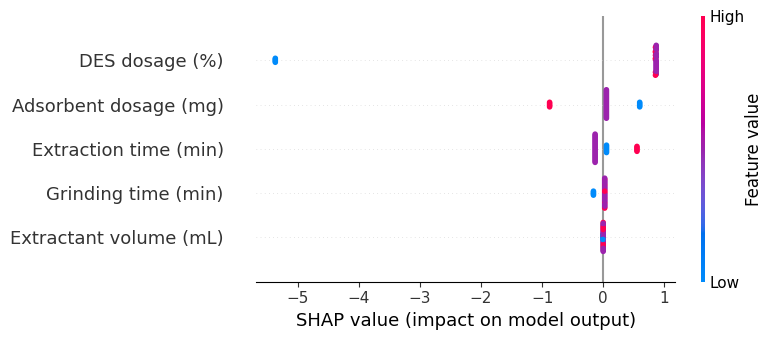

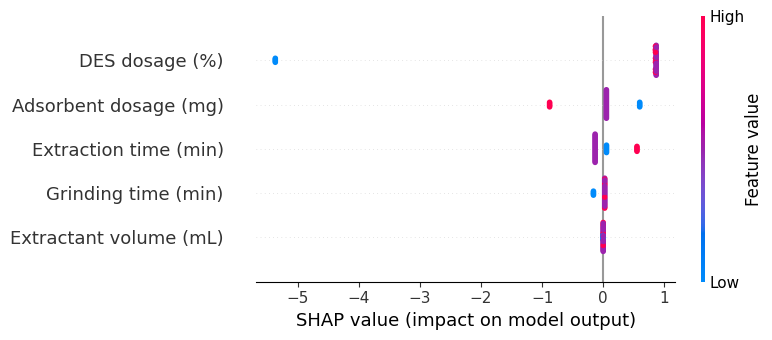

In [2]:
import shap
import matplotlib.pyplot as plt

# 计算 SHAP 值
explainer = shap.TreeExplainer(catboost_optimized)
shap_values = explainer.shap_values(X_train)

# 打印特征重要性
feature_importance = pd.DataFrame({
    'Feature': data.columns[:-1],  # 使用原始特征名称
    'Importance': np.mean(np.abs(shap_values), axis=0)
}).sort_values(by='Importance', ascending=False)

print("Feature Importance (SHAP Values):")
print(feature_importance)

# 保存 SHAP 特征重要性到 Excel
feature_importance.to_excel('SHAP_Feature_Importance.xlsx', index=False)

# 绘制 SHAP 值条形图
shap.summary_plot(shap_values, X_train, feature_names=data.columns[:-1])

# 绘制 SHAP 散点图
shap.summary_plot(shap_values, X_train, plot_type="dot", feature_names=data.columns[:-1])



In [9]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# 为每个特征绘制 PDP 图
feature_names = data.columns[:-1]  # 使用原始特征名称
output_folder = "PDP_Charts"  # 输出文件夹

os.makedirs(output_folder, exist_ok=True)  # 创建文件夹

for i, feature in enumerate(feature_names):
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # 绘制 PDP 图
    PartialDependenceDisplay.from_estimator(
        catboost_optimized,
        X_train,
        [i],
        ax=ax,
        feature_names=feature_names
    )
    
    # 图表格式美化
    ax.set_title(f"Partial Dependence of {feature}", fontsize=12)
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel("Partial Dependence", fontsize=10)
    plt.tight_layout()
    
    # 保存图表
    plt.savefig(f"{output_folder}/{feature}_PDP.png")
    plt.close(fig)

print(f"Partial dependence plots saved in folder: {output_folder}")


Partial dependence plots saved in folder: PDP_Charts


In [7]:
for i, feature in enumerate(feature_names):
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # 使用原始特征数据进行绘图
    PartialDependenceDisplay.from_estimator(
        catboost_optimized,
        scaler.inverse_transform(X_train),  # 逆标准化数据
        [i],
        ax=ax,
        feature_names=feature_names
    )
    
    # 图表格式美化
    ax.set_title(f"Partial Dependence of {feature}", fontsize=12)
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel("Partial Dependence", fontsize=10)
    plt.tight_layout()
    
    # 保存图表
    plt.savefig(f"{output_folder}/{feature}_PDP.png")
    plt.close(fig)


In [10]:
import os
import numpy as np
import random
import warnings
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = str(1)
np.random.seed(1)
random.seed(1)
warnings.filterwarnings("ignore")

# 1. Data Loading
data = pd.read_excel('machine.xlsx')  # Ensure the file path is correct
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Ensure data is numeric
if not np.issubdtype(X.dtypes, np.number):
    X = X.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, coerce invalid data
if not np.issubdtype(y.dtype, np.number):
    y = pd.to_numeric(y, errors='coerce')

# Check for invalid values
if X.isnull().any().any() or y.isnull().any():
    raise ValueError("Dataset contains invalid values (NaN or inf). Please check your data.")

# 2. Data Preprocessing
X_original = X.copy()  # Save the original data for PDP plots

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

# 3. Model Training
catboost_model = CatBoostRegressor(random_state=1, verbose=0)
catboost_model.fit(X_train, y_train)

# 4. Partial Dependence Plots (PDP)
feature_names = data.columns[:-1]  # Original feature names
output_folder = "PDP_Charts"  # Output folder for PDP charts

os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist

# Use original data for PDP plots
for i, feature in enumerate(feature_names):
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Generate PDP using original feature data
    PartialDependenceDisplay.from_estimator(
        catboost_model,
        X_original,  # Use original, unscaled data
        [i],
        ax=ax,
        feature_names=feature_names
    )
    
    # Beautify plot
    ax.set_title(f"Partial Dependence of {feature}", fontsize=12)
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel("Partial Dependence", fontsize=10)
    plt.tight_layout()
    
    # Save plot
    plt.savefig(f"{output_folder}/{feature}_PDP.png")
    plt.close(fig)

print(f"Partial dependence plots saved in folder: {output_folder}")


Partial dependence plots saved in folder: PDP_Charts


In [11]:
import os
import numpy as np
import random
import warnings
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = str(1)
np.random.seed(1)
random.seed(1)
warnings.filterwarnings("ignore")

# 1. Data Loading
data = pd.read_excel('machine.xlsx')  # Ensure the file path is correct
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Ensure data is numeric
if not np.issubdtype(X.dtypes, np.number):
    X = X.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, coerce invalid data
if not np.issubdtype(y.dtype, np.number):
    y = pd.to_numeric(y, errors='coerce')

# Check for invalid values
if X.isnull().any().any() or y.isnull().any():
    raise ValueError("Dataset contains invalid values (NaN or inf). Please check your data.")

# 2. Data Preprocessing
X_original = X.copy()  # Save the original data for reference

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

# 3. Model Training
catboost_model = CatBoostRegressor(random_state=1, verbose=0)
catboost_model.fit(X_train, y_train)

# 4. Partial Dependence Plots (PDP)
feature_names = data.columns[:-1]  # Original feature names
output_folder = "PDP_Charts"  # Output folder for PDP charts

os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist

# Use standardized data for PDP plots
for i, feature in enumerate(feature_names):
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Generate PDP using standardized feature data
    PartialDependenceDisplay.from_estimator(
        catboost_model,
        X_train,  # Use standardized data
        [i],
        ax=ax,
        feature_names=feature_names
    )
    
    # Beautify plot
    ax.set_title(f"Partial Dependence of {feature}", fontsize=12)
    ax.set_xlabel(f"{feature} (Standardized)", fontsize=10)  # Indicate standardized data
    ax.set_ylabel("Partial Dependence", fontsize=10)
    plt.tight_layout()
    
    # Save plot
    plt.savefig(f"{output_folder}/{feature}_PDP.png")
    plt.close(fig)

print(f"Partial dependence plots saved in folder: {output_folder}")


Partial dependence plots saved in folder: PDP_Charts


In [14]:
import os
import numpy as np
import random
import warnings
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import partial_dependence
import matplotlib.pyplot as plt

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = str(1)
np.random.seed(1)
random.seed(1)
warnings.filterwarnings("ignore")

# 1. Data Loading
data = pd.read_excel('machine.xlsx')  # Ensure the file path is correct
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Ensure data is numeric
if not np.issubdtype(X.dtypes, np.number):
    X = X.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, coerce invalid data
if not np.issubdtype(y.dtype, np.number):
    y = pd.to_numeric(y, errors='coerce')

# Check for invalid values
if X.isnull().any().any() or y.isnull().any():
    raise ValueError("Dataset contains invalid values (NaN or inf). Please check your data.")

# 2. Data Preprocessing
X_original = X.copy()  # Save the original data for reference

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

# 3. Model Training
catboost_model = CatBoostRegressor(random_state=1, verbose=0)
catboost_model.fit(X_train, y_train)

# 4. Partial Dependence Plots (PDP)
feature_names = data.columns[:-1]  # Original feature names
output_folder = "PDP_Charts"  # Output folder for PDP charts

os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist

# Generate PDP for each feature
for i, feature in enumerate(feature_names):
    # Calculate PDP values
    pdp_results = partial_dependence(
        catboost_model,
        X_train,  # Use standardized data
        [i]
    )
    grid_values = pdp_results['values'][0]  # Extract standardized grid values
    pdp_values = pdp_results['average'][0]  # PDP values

    # Map standardized grid values back to original scale
    original_values = scaler.inverse_transform(
        np.column_stack([grid_values if j == i else np.zeros_like(grid_values) for j in range(X.shape[1])])
    )[:, i]

    # Plot PDP with original values
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(original_values, pdp_values, label=f'Partial Dependence of {feature}')
    ax.set_title(f"Partial Dependence of {feature} (Original Scale)", fontsize=12)
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel("Partial Dependence", fontsize=10)
    ax.legend()
    plt.tight_layout()

    # Save the plot
    plt.savefig(f"{output_folder}/{feature}_PDP_Original.png")
    plt.close(fig)

print(f"Partial dependence plots saved in folder: {output_folder}")


Partial dependence plots saved in folder: PDP_Charts


In [16]:
import os
import numpy as np
import random
import warnings
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import partial_dependence
import matplotlib.pyplot as plt

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = str(1)
np.random.seed(1)
random.seed(1)
warnings.filterwarnings("ignore")

# 1. Data Loading
data = pd.read_excel('machine.xlsx')  # Ensure the file path is correct
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Ensure data is numeric
if not np.issubdtype(X.dtypes, np.number):
    X = X.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, coerce invalid data
if not np.issubdtype(y.dtype, np.number):
    y = pd.to_numeric(y, errors='coerce')

# Check for invalid values
if X.isnull().any().any() or y.isnull().any():
    raise ValueError("Dataset contains invalid values (NaN or inf). Please check your data.")

# 2. Data Preprocessing
X_original = X.copy()  # Save the original data for reference

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

# 3. Model Training
catboost_model = CatBoostRegressor(random_state=1, verbose=0)
catboost_model.fit(X_train, y_train)

# 4. Partial Dependence Plots (PDP)
feature_names = data.columns[:-1]  # Original feature names
output_folder = "PDP_Charts"  # Output folder for PDP charts

os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist

# Generate PDP for each feature
for i, feature in enumerate(feature_names):
    # Calculate PDP values
    pdp_results = partial_dependence(
        catboost_model,
        X_train,  # Use standardized data
        [i]
    )
    grid_values = pdp_results['values'][0]  # Extract standardized grid values
    pdp_values = pdp_results['average'][0]  # PDP values

    # Map standardized grid values back to original scale
    original_values = scaler.inverse_transform(
        np.column_stack([grid_values if j == i else np.zeros_like(grid_values) for j in range(X.shape[1])])
    )[:, i]

    # Plot PDP with original values
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(original_values, pdp_values)
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel("Partial Dependence", fontsize=10)
    plt.tight_layout()

    # Save the plot
    plt.savefig(f"{output_folder}/{feature}_PDP_Original.png")
    plt.close(fig)

print(f"Partial dependence plots saved in folder: {output_folder}")


Partial dependence plots saved in folder: PDP_Charts


In [3]:
import joblib
# 7. Save Model and Preprocessing Tools
joblib.dump(catboost_optimized, 'catboost_optimized.pkl')  # Save trained CatBoost model
joblib.dump(scaler, 'scaler.pkl')  # Save scaler used for feature normalization

['scaler.pkl']

In [4]:
import numpy as np
import joblib
import tkinter as tk
from tkinter import ttk

# Load saved models and preprocessing tools
model = joblib.load('catboost_optimized.pkl')
scaler = joblib.load('scaler.pkl')

# Prediction function
def predict_model(inputs):
    # Prepare input data
    data = np.array([inputs])
    
    # Data preprocessing
    data_scaled = scaler.transform(data)
    
    # Predict
    prediction = model.predict(data_scaled)
    return prediction[0]

# Create the main window
root = tk.Tk()
root.title("ML Prediction for Extraction Yield")
root.geometry("900x600")
root.configure(bg="#E3F2FD")

# Title label
title_label = tk.Label(root, text="ML Prediction for Extraction Yield", font=("Poppins", 24, "bold"), fg="#0D47A1", bg="#E3F2FD")
title_label.grid(row=0, column=0, columnspan=2, pady=20)

# Create labeled entry fields for input parameters
def create_labeled_entry(parent, text, row):
    label = tk.Label(parent, text=text, font=("Poppins", 14), fg="#333333", bg=parent["bg"])
    label.grid(row=row, column=0, padx=20, pady=10, sticky=tk.W)
    
    entry = ttk.Entry(parent, width=25)
    entry.grid(row=row, column=1, padx=20, pady=10)
    
    return entry

# Input fields
inputs = {}
input_params = [
    "Adsorbent dosage (mg):",
    "Grinding time (min):",
    "DES dosage (%):",
    "Extractant volume (mL):",
    "Extraction time (min):"
]

for i, param in enumerate(input_params):
    inputs[param] = create_labeled_entry(root, param, i + 1)

# Predict button handler
def handle_predict():
    try:
        input_values = [float(inputs[param].get()) for param in input_params]
        prediction = predict_model(input_values)
        result_label.config(text=f'Predicted Extraction Yield: {prediction:.2f} mg/g', fg="#2E7D32")
    except ValueError:
        result_label.config(text="Please enter valid numeric values.", fg="red")

# Predict button
predict_button = ttk.Button(root, text="Predict", command=handle_predict, style='Custom.TButton')
predict_button.grid(row=len(input_params) + 1, column=0, columnspan=2, pady=30)

# Result label
result_label = tk.Label(root, text="Prediction will appear here", font=("Poppins", 16), fg="#333333", bg="#E3F2FD")
result_label.grid(row=len(input_params) + 2, column=0, columnspan=2, pady=15)

# Run the Tkinter main loop
root.mainloop()


In [5]:
import numpy as np
import joblib
import tkinter as tk
from tkinter import ttk

# Load saved models and preprocessing tools
model = joblib.load('catboost_optimized.pkl')
scaler = joblib.load('scaler.pkl')

# Prediction function
def predict_model(inputs):
    # Prepare input data
    data = np.array([inputs])
    
    # Data preprocessing
    data_scaled = scaler.transform(data)
    
    # Predict
    prediction = model.predict(data_scaled)
    return prediction[0]

# Create the main window
root = tk.Tk()
root.title("ML Prediction for Extraction Yield")
root.geometry("900x600")
root.configure(bg="#F5F5F5")

# Title label
title_label = tk.Label(root, text="ML Prediction for Extraction Yield", font=("Arial", 26, "bold"), fg="#1A237E", bg="#F5F5F5")
title_label.grid(row=0, column=0, columnspan=2, pady=20)

# Create labeled entry fields for input parameters
def create_labeled_entry(parent, text, row):
    label = tk.Label(parent, text=text, font=("Arial", 14), fg="#424242", bg=parent["bg"])
    label.grid(row=row, column=0, padx=20, pady=10, sticky=tk.W)
    
    entry = ttk.Entry(parent, width=25)
    entry.grid(row=row, column=1, padx=20, pady=10)
    
    return entry

# Input fields
inputs = {}
input_params = [
    "Adsorbent dosage (mg):",
    "Grinding time (min):",
    "DES dosage (%):",
    "Extractant volume (mL):",
    "Extraction time (min):"
]

for i, param in enumerate(input_params):
    inputs[param] = create_labeled_entry(root, param, i + 1)

# Predict button handler
def handle_predict():
    try:
        input_values = [float(inputs[param].get()) for param in input_params]
        prediction = predict_model(input_values)
        result_label.config(text=f'Predicted Extraction Yield: {prediction:.2f} mg/g', fg="#2E7D32")
    except ValueError:
        result_label.config(text="Please enter valid numeric values.", fg="red")

# Predict button
style = ttk.Style()
style.configure('Custom.TButton', font=("Arial", 14), padding=10)

predict_button = ttk.Button(root, text="Predict", command=handle_predict, style='Custom.TButton')
predict_button.grid(row=len(input_params) + 1, column=0, columnspan=2, pady=30)

# Result label
result_label = tk.Label(root, text="Prediction will appear here", font=("Arial", 16), fg="#424242", bg="#F5F5F5")
result_label.grid(row=len(input_params) + 2, column=0, columnspan=2, pady=15)

# Run the Tkinter main loop
root.mainloop()


In [6]:
import numpy as np
import joblib
import tkinter as tk
from tkinter import ttk

# Load saved models and preprocessing tools
model = joblib.load('catboost_optimized.pkl')
scaler = joblib.load('scaler.pkl')

# Prediction function
def predict_model(inputs):
    # Prepare input data
    data = np.array([inputs])
    
    # Data preprocessing
    data_scaled = scaler.transform(data)
    
    # Predict
    prediction = model.predict(data_scaled)
    return prediction[0]

# Create the main window
root = tk.Tk()
root.title("ML Prediction for Extraction Yield")
root.geometry("1000x650")
root.configure(bg="#E3F2FD")

# Title label
title_label = tk.Label(root, text="ML Prediction for Extraction Yield", font=("Helvetica", 28, "bold"), fg="#0D47A1", bg="#E3F2FD")
title_label.grid(row=0, column=0, columnspan=2, pady=20)

# Create labeled entry fields for input parameters
def create_labeled_entry(parent, text, row):
    label = tk.Label(parent, text=text, font=("Helvetica", 16), fg="#333333", bg=parent["bg"])
    label.grid(row=row, column=0, padx=20, pady=10, sticky=tk.W)
    
    entry = ttk.Entry(parent, width=30)
    entry.grid(row=row, column=1, padx=20, pady=10)
    
    return entry

# Input fields
inputs = {}
input_params = [
    "Adsorbent dosage (mg):",
    "Grinding time (min):",
    "DES dosage (%):",
    "Extractant volume (mL):",
    "Extraction time (min):"
]

for i, param in enumerate(input_params):
    inputs[param] = create_labeled_entry(root, param, i + 1)

# Predict button handler
def handle_predict():
    try:
        input_values = [float(inputs[param].get()) for param in input_params]
        prediction = predict_model(input_values)
        result_label.config(text=f'Predicted Extraction Yield: {prediction:.2f} mg/g', fg="#2E7D32")
    except ValueError:
        result_label.config(text="Please enter valid numeric values.", fg="red")

# Predict button
style = ttk.Style()
style.configure('Custom.TButton', font=("Helvetica", 16), padding=10)

predict_button = ttk.Button(root, text="Predict", command=handle_predict, style='Custom.TButton')
predict_button.grid(row=len(input_params) + 1, column=0, columnspan=2, pady=30)

# Result label
result_label = tk.Label(root, text="Prediction will appear here", font=("Helvetica", 18, "bold"), fg="#1B5E20", bg="#E3F2FD")
result_label.grid(row=len(input_params) + 2, column=0, columnspan=2, pady=15)

# Run the Tkinter main loop
root.mainloop()


In [7]:
import numpy as np
import joblib
import tkinter as tk
from tkinter import ttk

# Load saved models and preprocessing tools
model = joblib.load('catboost_optimized.pkl')
scaler = joblib.load('scaler.pkl')

# Prediction function
def predict_model(inputs):
    # Prepare input data
    data = np.array([inputs])
    
    # Data preprocessing
    data_scaled = scaler.transform(data)
    
    # Predict
    prediction = model.predict(data_scaled)
    return prediction[0]

# Create the main window
root = tk.Tk()
root.title("ML Prediction for Extraction Yield")
root.geometry("1000x650")
root.configure(bg="#FFF8DC")

# Title label
title_label = tk.Label(root, text="ML Prediction for Extraction Yield", font=("Helvetica", 28, "bold"), fg="#0D47A1", bg="#FFF8DC")
title_label.grid(row=0, column=0, columnspan=2, pady=20)

# Create labeled entry fields for input parameters
def create_labeled_entry(parent, text, row):
    label = tk.Label(parent, text=text, font=("Helvetica", 16), fg="#333333", bg=parent["bg"])
    label.grid(row=row, column=0, padx=20, pady=10, sticky=tk.W)
    
    entry = ttk.Entry(parent, width=30)
    entry.grid(row=row, column=1, padx=20, pady=10)
    
    return entry

# Input fields
inputs = {}
input_params = [
    "Adsorbent dosage (mg):",
    "Grinding time (min):",
    "DES dosage (%):",
    "Extractant volume (mL):",
    "Extraction time (min):"
]

for i, param in enumerate(input_params):
    inputs[param] = create_labeled_entry(root, param, i + 1)

# Predict button handler
def handle_predict():
    try:
        input_values = [float(inputs[param].get()) for param in input_params]
        prediction = predict_model(input_values)
        result_label.config(text=f'Predicted Extraction Yield: {prediction:.2f} mg/g', fg="#2E7D32")
    except ValueError:
        result_label.config(text="Please enter valid numeric values.", fg="red")

# Predict button
style = ttk.Style()
style.configure('Custom.TButton', font=("Helvetica", 16), padding=10)

predict_button = ttk.Button(root, text="Predict", command=handle_predict, style='Custom.TButton')
predict_button.grid(row=len(input_params) + 1, column=0, columnspan=2, pady=30)

# Result label
result_label = tk.Label(root, text="Prediction will appear here", font=("Helvetica", 18, "bold"), fg="#1B5E20", bg="#FFF8DC")
result_label.grid(row=len(input_params) + 2, column=0, columnspan=2, pady=15)

# Run the Tkinter main loop
root.mainloop()

In [8]:
import numpy as np
import joblib
import tkinter as tk
from tkinter import ttk

# Load saved models and preprocessing tools
model = joblib.load('catboost_optimized.pkl')
scaler = joblib.load('scaler.pkl')

# Prediction function
def predict_model(inputs):
    # Prepare input data
    data = np.array([inputs])
    
    # Data preprocessing
    data_scaled = scaler.transform(data)
    
    # Predict
    prediction = model.predict(data_scaled)
    return prediction[0]

# Create the main window
root = tk.Tk()
root.title("ML Prediction for Extraction Yield")
root.geometry("1000x650")
root.configure(bg="#FFF8DC")

# Title label
title_label = tk.Label(root, text="ML Prediction for Extraction Yield", font=("Helvetica", 28, "bold"), fg="#0D47A1", bg="#FFF8DC")
title_label.grid(row=0, column=0, columnspan=2, pady=20)

# Create labeled entry fields for input parameters
def create_labeled_entry(parent, text, row):
    label = tk.Label(parent, text=text, font=("Helvetica", 16), fg="#333333", bg=parent["bg"])
    label.grid(row=row, column=0, padx=20, pady=10, sticky=tk.W)
    
    entry = ttk.Entry(parent, width=30, font=("Helvetica", 14))
    entry.grid(row=row, column=1, padx=20, pady=10)
    
    return entry

# Input fields
inputs = {}
input_params = [
    "Adsorbent dosage (mg):",
    "Grinding time (min):",
    "DES dosage (%):",
    "Extractant volume (mL):",
    "Extraction time (min):"
]

for i, param in enumerate(input_params):
    inputs[param] = create_labeled_entry(root, param, i + 1)

# Predict button handler
def handle_predict():
    try:
        input_values = [float(inputs[param].get()) for param in input_params]
        prediction = predict_model(input_values)
        result_label.config(text=f'Predicted Extraction Yield: {prediction:.2f} mg/g', fg="#2E7D32")
    except ValueError:
        result_label.config(text="Please enter valid numeric values.", fg="red")

# Predict button
style = ttk.Style()
style.configure('Custom.TButton', font=("Helvetica", 16), padding=10)

predict_button = ttk.Button(root, text="Predict", command=handle_predict, style='Custom.TButton')
predict_button.grid(row=len(input_params) + 1, column=0, columnspan=2, pady=30)

# Result label
result_label = tk.Label(root, text="Prediction will appear here", font=("Helvetica", 18, "bold"), fg="#1B5E20", bg="#FFF8DC")
result_label.grid(row=len(input_params) + 2, column=0, columnspan=2, pady=15)

# Run the Tkinter main loop
root.mainloop()
